#### **0. References**



1. **ChatGPT**: acting as the masked autoencoder for my masked understanding.


#### **1. Libraries**

In [485]:
# Standard Library Imports
import sys
import os
import random
import pathlib
import time
import copy
from collections import Counter

# Third-Party Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from skimage.transform import resize
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from sklearn.metrics import mean_squared_error


In [486]:
## GPU check and version check ##
!nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
print( 'python version : ',sys.version) 
print( 'torch version  : ',torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

NVIDIA GeForce RTX 4070 Ti SUPER, 16376 MiB
python version :  3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:06:27) [MSC v.1942 64 bit (AMD64)]
torch version  :  2.5.1+cu121


#### **2. General utils**

In [ ]:
## Utility Functions ##
def set_seed(seed):
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True # only applies to CUDA convolutional operation.
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.use_deterministic_algorithms(True,warn_only=False)

def mean_std(train_dataset, device):
    train_dataloader = DataLoader(train_dataset, batch_size=4096, shuffle=False)
    train_data = []

    for lr_image_batch,_ in tqdm(train_dataloader):
        lr_image_batch = lr_image_batch.to(device)
        train_data.append(lr_image_batch)
    
    train_data = torch.cat(train_data, dim=0)
    mean = train_data.mean()
    std = train_data.std()

    return mean, std

def visualize_random_pairs_side_by_side(dataset, num_pairs=3):
    """
    Display 'num_pairs' randomly chosen LR-HR pairs side by side in a smaller,
    high-quality figure. Resizes the LR images to match the HR dimensions so
    both can be directly compared in one frame.
    
    Args:
        dataset (Dataset): An instance of CustomDataset (or any dataset returning (LR, HR) pairs).
        num_pairs (int): Number of random LR-HR pairs to visualize.
    """
    # Randomly pick indices
    indices = random.sample(range(len(dataset)), num_pairs)
    
    for i, idx in enumerate(indices, start=1):
        lr_img, hr_img = dataset[idx]
        
        # Convert tensors to NumPy arrays
        lr_np = lr_img.squeeze().detach().cpu().numpy()
        hr_np = hr_img.squeeze().detach().cpu().numpy()
        
        # Resize LR to match HR shape for side-by-side display
        lr_resized = resize(lr_np, hr_np.shape, anti_aliasing=True)
        
        # Concatenate horizontally
        # The resulting image has shape: (height, width_LR + width_HR)
        side_by_side = np.hstack((lr_resized, hr_np))
        
        # Show the combined image
        plt.figure(figsize=(8, 4), dpi=150)  # Smaller figure with higher DPI
        plt.imshow(side_by_side, cmap='gray')  # Display as grayscale
        plt.title(f"Pair #{i}: LR (left) | HR (right)")
        plt.axis('off')
        plt.show()

#### **3. Dataset utils**

In [17]:
class CustomDataset(Dataset): # inherits from torch.utils.data.Dataset class
    def __init__(self, target_dir, transform=None):
        self.target_dir = target_dir
        lr_images_path = os.path.join(target_dir, 'LR')    
        self.paths = [os.path.join(lr_images_path, file) for file in os.listdir(lr_images_path) if file.endswith('.npy')]
        # get all paths of low-resolution images in the target directory
        self.transform = transform
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        lr_img_path = self.paths[index]
        filename = os.path.basename(lr_img_path)

        lr_img = np.load(lr_img_path) # (1,75,75)      
        lr_img = torch.tensor(lr_img, dtype=torch.float32)

        hr_img_path = os.path.join(self.target_dir, 'HR', filename)
        hr_img = np.load(hr_img_path) # (1,150,150)
        hr_img = torch.tensor(hr_img, dtype=torch.float32)
        

        if self.transform:
            lr_img = self.transform(lr_img)
        
        return lr_img, hr_img # (1,75,75), (1,150,150)  

#### **4. Training utils** 

In [ ]:
class Trainer:
    def __init__(self, model, device, HP ):
        self.model = model
        self.device =device
        self.epochs = HP['num_epochs']
        self.batch_size = HP['batch_size']
        self.lr = HP['lr']
        self.weight_decay = HP['weight_decay']
    
    def model_train(self, train_loader, val_loader):

        criteria = nn.MSELoss()
        optimizer = Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1) # every 10 epochs, lr = lr * 0.1

        for epoch in range(self.epochs):
            self.model.train() 

            running_loss = 0.0  
            total_batches = 0 

            for lr_img,hr_img in train_loader:
                lr_img = lr_img.to(self.device)
                hr_img = hr_img.to(self.device)

                optimizer.zero_grad()
                sr_img = self.model(lr_img)
                loss = criteria(sr_img, hr_img)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                total_batches += 1
            
            # step the scheduler    
            scheduler.step()

            # calculate the average loss for the epoch  
            epoch_loss = running_loss/total_batches 

            print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {epoch_loss:.8f}")

    print( "Training complete.")    

    def eval_model(model, test_loader, device):
        model = model.to(device)  
        model.eval() 
        with torch.no_grad():  
            total_psnr = 0.0
            total_ssim = 0.0
            total_mse = 0.0
            total_images = 0
            
            for lr,hr in test_loader:
                lr, hr
                sr = model(lr)
                
                sr_np = sr.cpu().numpy()
                hr_np = hr.cpu().numpy()
                
                batch_size = sr_np.shape[0]
                total_images += batch_size
                
                for i in range(batch_size):
                    
                    sr_img = sr_np[i].squeeze()  
                    hr_img = hr_np[i].squeeze()
                    
                    psnr = compare_psnr(hr_img, sr_img, data_range=hr_img.max() - hr_img.min())
                    ssim = compare_ssim(hr_img, sr_img, data_range=hr_img.max() - hr_img.min())
                    mse = mean_squared_error(hr_img, sr_img)
                    
                    total_psnr += psnr
                    total_ssim += ssim
                    total_mse += mse
            
            # Calculate average PSNR, SSIM, and MSE
            avg_psnr = total_psnr / total_images
            avg_ssim = total_ssim / total_images
            avg_mse = total_mse / total_images
            
            print(f'Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}, Average MSE: {avg_mse:.4f}')

#### **5. Finetuning pre-trained MAE for SISR**

##### *5.1 Config*

In [13]:
## TO-CHANGE CELL ##
HP={
'seed': 100, 
'lr': 1e-4,
'batch_size': 256,
'num_epochs':40,
'weight_decay': 0
}

data_dir = r'dataset'
model_path = r'saved_models\best_model_60epochs_zscore.pth'
## TO-CHANGE CELL ##


##### *5.2 Data loading and visualisation*

The dataset consists of simulated strong lensing images without substructure, available at two different resolutions:

- **High-Resolution (HR):** 10,000 images stored as NumPy arrays of shape `(1, 150, 150)`, with pixel values in the range `[0, 1]` .
- **Low-Resolution (LR):** 10,000 images stored as NumPy arrays of shape `(1, 75, 75)`, with pixel values somewhat in between 0 and 1, but sometimes slightly greater than 1. ( Probably the LR image is obtained from the HR image after using some statistical image resecaling techniques)

For our purposes, the dataset was randomly split into training, validation, and test sets in an **80:10:10** ratio. 

The final performance of the model was evaluated on the test set using the following metrics:  
**Mean Squared Error (MSE)**, **Peak Signal-to-Noise Ratio (PSNR)**, and **Structural Similarity Index (SSIM)**.


In [479]:
## S1 : DATA LOADING ##

set_seed(HP['seed'])
dataset = CustomDataset(data_dir)

from torch.utils.data import random_split  

# Define split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1* len(dataset))   # 10% for validation
test_size = len(dataset) - train_size - val_size  # 10% for testing 

# Perform two-step random splitting
train_dataset, temp_dataset = random_split(dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

# Check the sizes of the splits 
print(f"Training set size   : {len(train_dataset)}")   
print(f"Validation set size : {len(val_dataset)}")
print(f"Testing set size    : {len(test_dataset)}")



Training set size   : 8000
Validation set size : 1000
Testing set size    : 1000


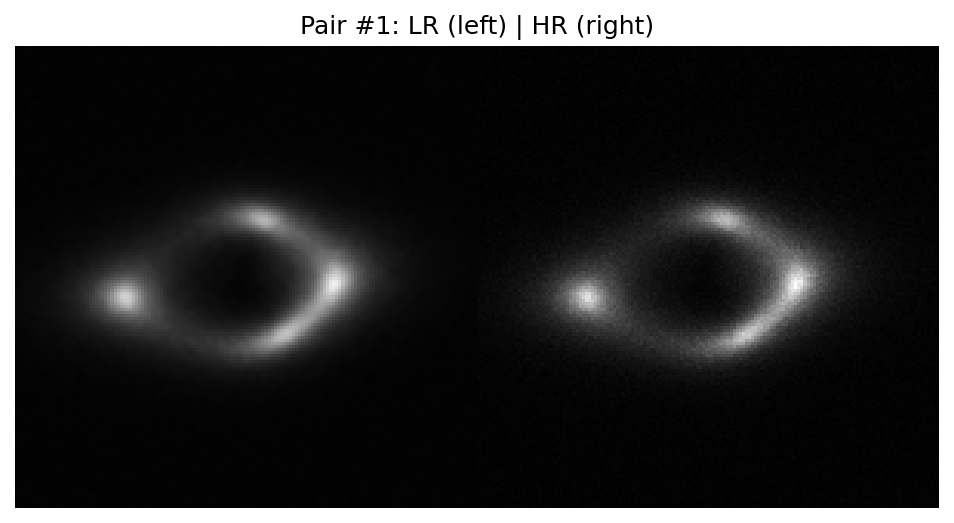

In [482]:
visualize_random_pairs_side_by_side(dataset, num_pairs=1) # visualize random pairs of LR-HR images 

In [476]:
# Check the mean, std, min, max of any random LR-HR image pair  
random_num = random.randint(0, len(dataset)-1)
lr_image, hr_image = dataset[random_num]
lr_image = lr_image.squeeze().detach().cpu().numpy()
hr_image = hr_image.squeeze().detach().cpu().numpy()
print( 'lr_image mean : ',lr_image.mean(),' std : ',lr_image.std(),' min : ',lr_image.min(),' max : ',lr_image.max())
print( 'hr_image mean : ',hr_image.mean(),' std : ',hr_image.std(),' min : ',hr_image.min(),' max : ',hr_image.max())   

    

lr_image mean :  0.06133488  std :  0.104547575  min :  0.0017995932  max :  0.95373034
hr_image mean :  0.06133488  std :  0.10457513  min :  0.0  max :  1.0


In [ ]:
# Create data loaders   
from torch.utils.data import DataLoader 

train_loader = DataLoader(train_dataset, batch_size=HP['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=HP['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=HP['batch_size'], shuffle=False)     

train_loader length :  32
val_loader length :  4
test_loader length :  4


##### *5.3 Model Definition*

In [ ]:
## S2 : MODEL DEFINING ##

class MAE_encoder(nn.Module):
    def __init__(self, pretrained_model):
        super(MAE_encoder, self).__init__()
        self.encoder = pretrained_model.encoder 
        self.patch_embed = self.encoder.patch_embed 
        self.patchify = self.encoder.patchify   
        self.cls_token = self.encoder.cls_token 
        self.pos_embed = self.encoder.pos_embed 
        self.blocks = self.encoder.blocks
        self.layer_norm = self.encoder.norm

        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(64, 3)
        )
        
        self.init_weights()
    def init_weights(self):
        for m in self.classifier:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # x (B,1,64,64) <=? (B,C,H,W)
    
        x = self.patch_embed(x) # (B, 64, 128) <=> (B, seq_len, d_model) 
        x = x + self.pos_embed[:,1:,:]  # (B, 64, 128)

        # appending cls token to the input
        cls_token = self.cls_token + self.pos_embed[:,0:1,:] # (1, 1, 128)
        cls_tokens = cls_token.expand(x.shape[0], -1, -1) # (B, 1, 128)
        x = torch.cat((cls_tokens, x), dim=1) # (B, 65, 128)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        
        x = self.layer_norm(x) # (B, 65, 128)
        
        x = x[:,1:,:] # (B, 64, 128) <=> (B, seq_len, d_model)  
        x = self.avg_pool(x) # (B, 64, 1)
        x = x.squeeze(-1) # (B, 64)
        output = self.classifier(x) # (B, 3)

        return output   
   


##### *5.4 Training*

In [ ]:
set_seed(HP['seed'])    

pretrained_model = torch.load(model_path) 
model = MAE_encoder(pretrained_model).to( device )
print( 'Trainable parameters :', sum(p.numel() for p in model.parameters() if p.requires_grad) )

trainer = Trainer(model,device, HP)
trainer.model_train(train_loader, val_loader)   


##### *5.4 Inference*